%matplotlib inline
from itertools import cycle
from os import listdir
from os.path import exists, isdir, join
from glob import glob
from scipy.interpolate import interp1d, splrep, splev

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [4]:
from utils import load_file

In [5]:
def get_subdirs(path, level=1):
    dirs = sorted(listdir(path))
    for directory in dirs:
        joined = join(path, directory)
        # Check if the item is directory and if the current
        # level is the deepest allowed
        if isdir(joined) and level == 1:
            # Reached the deepest level, return directory
            yield directory
        elif isdir(joined) and level > 1:
            # Go through all sub directories in current directory
            for subdir in get_subdirs(joined, level=level-1):
                yield join(directory, subdir)

In [6]:
# path_directory = 'X:/SSI/20160621_mapping/03_test/' 
path_directory = 'X:/SSI/20170111_together/03_test' 
path_results = 'results/hvite/'
level=2

In [13]:
# dirs = sorted(listdir(path_directory))
# directories = [join(directory, path_results) for directory in get_subdirs(path_directory, level=level)]
dirs = [directory for directory in get_subdirs(path_directory, level=level)]
dirs_full_paths = [join(path_directory, directory, path_results) for directory in dirs]

print('Directories:', dirs)

Directories: ['PLP16_CMN\\t-n', 'PLP16_CMN\\t-no', 'PLP16_CMN\\t-o', 'PLP3D16V1a_C3A\\t-n', 'PLP3D16V1a_C3A\\t-no', 'PLP3D16V1a_C3A\\t-o']


### Accuracy

In [8]:
def reglob(path, exp, invert=False):
    """glob.glob() style searching which uses regex

    :param exp: Regex expression for filename
    :param invert: Invert match to non matching files
    """

    m = re.compile(exp)

    if invert is False:
        res = [f for f in listdir(path) if m.search(f)]
    else:
        res = [f for f in listdir(path) if not m.search(f)]

    res = map(lambda x: "%s/%s" % ( path, x, ), res)
    return res

In [9]:
def get_accuracy(files):
    re_acc_pattern = re.compile('word:.+Acc=([-]*\d+\.\d+)', re.I)
    re_lm_weight = re.compile('lm-w(\d+)')
    
    for file in files:
        weight = re_lm_weight.search(file).group(1)
        
        for line in load_file(file):
            match = re_acc_pattern.match(line)
            if not match:
                continue
            yield int(weight), float(match.group(1))

In [10]:
colors = cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k', '#348ABD', '#fdb462', '#CC79A7', '#8C0900', '#E5E5E5'])

def draw_accuracy(accuracy, name):
    # Unzip weight and accuracy.   
#     accuracy = sorted(accuracy)
    x, y = zip(*accuracy)
    xmax = max(x)
    # Extrapolate
    xnew = np.linspace(1, xmax * 1.1, num=60, endpoint=True)
    tck = splrep(x, y, k=2, s=0)
    ynew = splev(xnew, tck)
    
    # Plot    
    color = next(colors)
    plt.plot(xnew, ynew, '-', c=color, label=name)
    plt.plot(x, y, 'o', xnew, [max(y)] * 60, '--', c=color)
    plt.xlabel('Insertion penalty')
    plt.ylabel('Accuracy')
    
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
    
    return max(accuracy, key=lambda x: x[1])

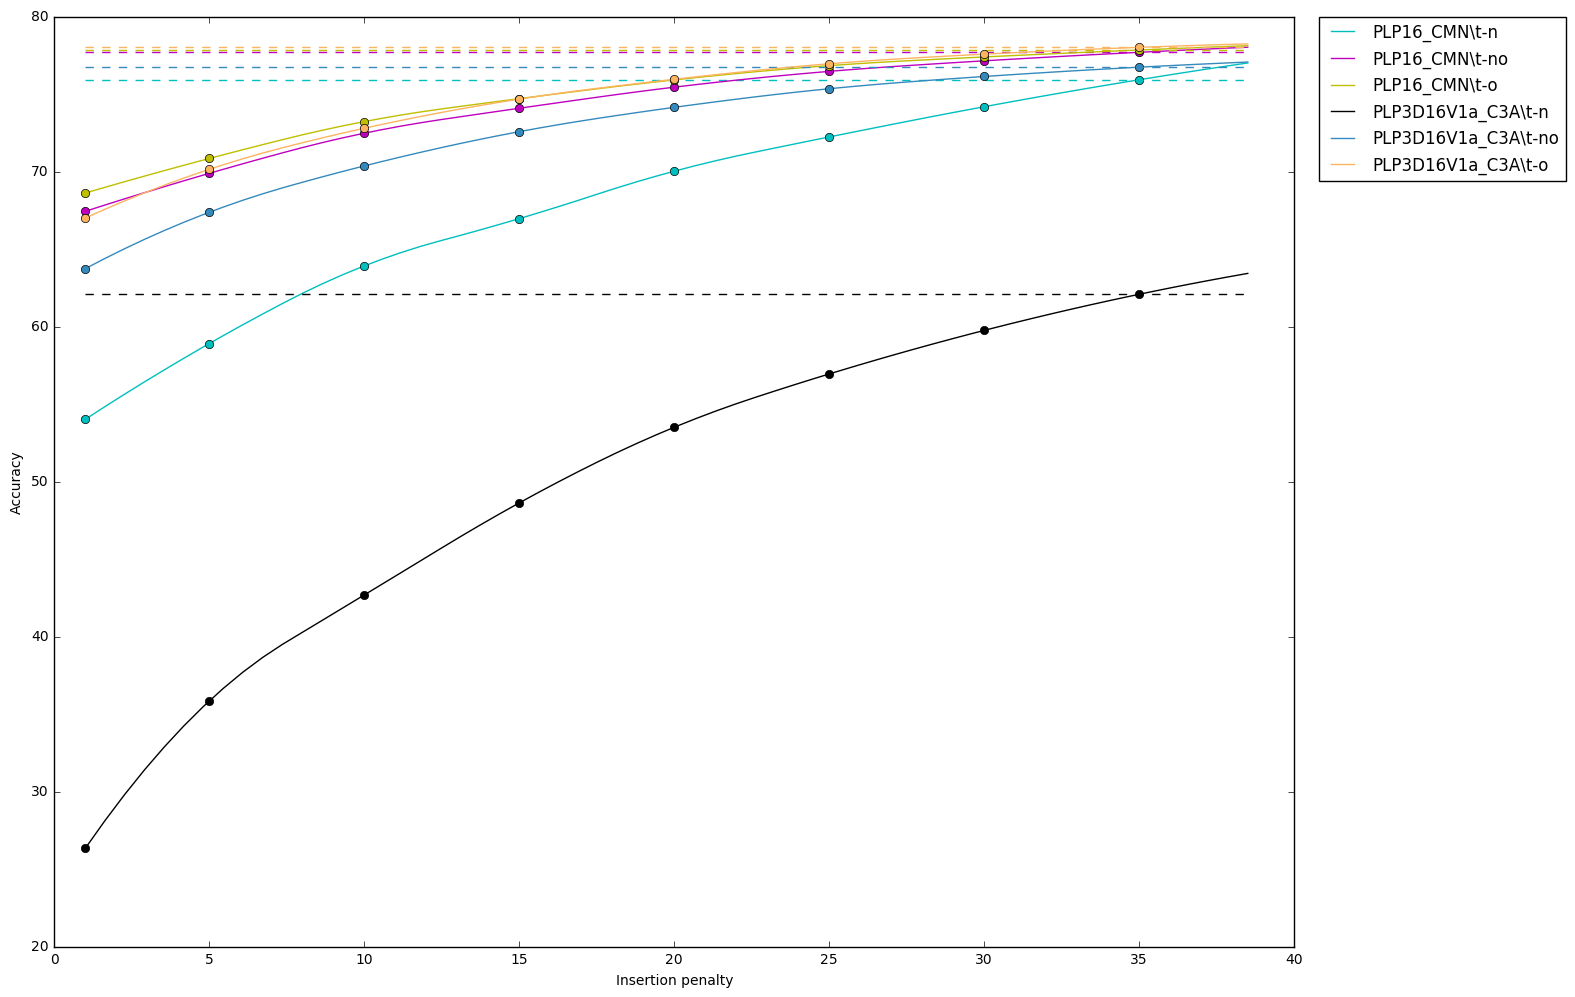

In [14]:
fig = plt.figure(figsize=(16, 12), dpi=120, facecolor='w', edgecolor='k')
columns = ['type', 'accuracy', 'weight']
df = pd.DataFrame(columns=columns)

for directory, path in zip(dirs, dirs_full_paths):
    if not exists(path):
        continue
    paths = reglob(path, 'hvite_t01_lm-w[0-9]+.pyeval.txt')
    accuracy = sorted(get_accuracy(paths))
    # We need at least 3 poinst for interpolation
    if len(accuracy) < 3:
        continue
    weight, value = draw_accuracy(accuracy, directory)
    df = df.append(pd.DataFrame([[directory, value, weight]], columns=columns), ignore_index=True)

plt.savefig(join(path_directory, 'summary_accuracy.png'), format='png')
plt.show()

In [16]:
df.to_csv(join(path_directory, 'summary_accuracy.csv'), sep=';', encoding='utf-8')
print(df.sort_values(by=['accuracy'], ascending=[0]))

                  type  accuracy  weight
5   PLP3D16V1a_C3A\t-o     78.01    35.0
2        PLP16_CMN\t-o     77.84    35.0
1       PLP16_CMN\t-no     77.69    35.0
4  PLP3D16V1a_C3A\t-no     76.73    35.0
0        PLP16_CMN\t-n     75.92    35.0
3   PLP3D16V1a_C3A\t-n     62.08    35.0
